In [85]:
import pycaret
import pandas as pd

In [86]:
# อ่านไฟล์ CSV
data = pd.read_csv('../export_data/filtered_data_3_best.csv')

In [87]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data = data.asfreq('D')  # 'D' สำหรับรายวัน

In [88]:
data.tail()

,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature
timestamp,,,,,
2025-02-07 07:00:00,70.933952,34.743259,29.321219,26.166471,28.271927
2025-02-08 07:00:00,69.348548,30.654249,26.000000,22.380675,28.385596
2025-02-09 07:00:00,69.916384,28.971065,24.616898,20.976852,28.373742
2025-02-10 07:00:00,71.226336,30.652667,25.856981,22.374574,28.251201
2025-02-11 07:00:00,68.159624,32.532955,27.522727,24.120455,28.693799


In [89]:
# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data[data.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data[data.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")


row = data.loc["2023-09-30 07:00:00"]
row

แถวที่มีค่าหายไปก่อนเติม:
                     humidity  pm_10  pm_2_5  pm_2_5_sp  temperature
timestamp                                                           
2023-09-30 07:00:00       NaN    NaN     NaN        NaN          NaN
ไม่มีค่าหายไปแล้ว


humidity       82.889367
pm_10          60.525519
pm_2_5         53.415241
pm_2_5_sp      69.527667
temperature    29.219760
Name: 2023-09-30 07:00:00, dtype: float64

In [90]:
data = data[['pm_2_5', 'humidity', 'temperature']]

In [91]:
data["year"] = data.index.year
data["month"] = data.index.month
data["day"] = data.index.day
data["day_of_week"] = data.index.dayofweek  # 0 = Monday, 6 = Sunday
data["week_of_year"] = data.index.isocalendar().week  # ค่าจะเป็น int64

In [92]:
# สมมติว่า data มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data["season"] = data.index.month.map(assign_season)
data['season'] = data['season'].map(season_mapping)

In [93]:
data['dew_point'] = data['temperature'] - ((100 - data['humidity']) / 5)

In [94]:
data["is_weekend"] = data.index.dayofweek.isin([5, 6]).astype(int)

In [95]:
# อัตราส่วนของอุณหภูมิต่อความชื้น
data["temp_humidity_ratio"] = data["temperature"] / (data["humidity"] + 1)

In [96]:
# ดัชนีความร้อน (Heat Index) หรืออุณหภูมิที่รับรู้
T = data["temperature"]
RH = data["humidity"]

data["heat_index"] = -42.379 + (2.04901523 * T) + (10.14333127 * RH) - (0.22475541 * T * RH) - \
                   (0.00683783 * T**2) - (0.05481717 * RH**2) + (0.00122874 * T**2 * RH) + \
                   (0.00085282 * T * RH**2) - (0.00000199 * T**2 * RH**2)

In [97]:
# ความชื้นสัมพัทธ์เชิงดัชนี
data["rh_index"] = data["humidity"] ** 2 / (data["temperature"] + 1)

In [98]:
import pandas as pd
import numpy as np

# สมมุติว่ามี DataFrame data ที่มีข้อมูลอยู่แล้ว
# เพิ่มฟีเจอร์ day_of_year
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['day_of_year'] = data['date'].dt.dayofyear

# เพิ่มฟีเจอร์ month_sin และ month_cos
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

rolling_size = 14
for i in range(2,rolling_size+1):
    data[f'pm_2_5_rolling_{i}'] = data['pm_2_5'].rolling(window=i).mean().shift(1)

lag_size = 30
for i in range(1,lag_size+1):
    data[f'pm_2_5_lag_{i}'] = data['pm_2_5'].shift(i)

# data['humidity_rolling_2'] = data['humidity'].rolling(window=2).mean().shift(1)  # ค่าเฉลี่ย 2 วันของ PM 10
# data['humidity_rolling_5'] = data['humidity'].rolling(window=5).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10
# data['humidity_rolling_7'] = data['humidity'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 7 วันของ PM 10

data['humidity_lag_1'] = data['humidity'].shift(1)
data['humidity_lag_2'] = data['humidity'].shift(2)
data['humidity_lag_3'] = data['humidity'].shift(3)
data['humidity_lag_7'] = data['humidity'].shift(7)

# data['temperature_rolling_2'] = data['temperature'].rolling(window=2).mean().shift(1)  # ค่าเฉลี่ย 2 วันของ PM 10
# data['temperature_rolling_5'] = data['temperature'].rolling(window=5).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10
# data['temperature_rolling_7'] = data['temperature'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 7 วันของ PM 10

data['temperature_lag_1'] = data['temperature'].shift(1)
data['temperature_lag_2'] = data['temperature'].shift(2)
data['temperature_lag_3'] = data['temperature'].shift(3)
data['temperature_lag_7'] = data['temperature'].shift(7)

In [99]:
# data["temp_diff"] = data["temperature"].diff()
# data["humidity_diff"] = data["humidity"].diff()

In [100]:
data.columns

Index(['pm_2_5', 'humidity', 'temperature', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'season', 'dew_point', 'is_weekend',
       'temp_humidity_ratio', 'heat_index', 'rh_index', 'date', 'day_of_year',
       'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
       'pm_2_5_rolling_2', 'pm_2_5_rolling_3', 'pm_2_5_rolling_4',
       'pm_2_5_rolling_5', 'pm_2_5_rolling_6', 'pm_2_5_rolling_7',
       'pm_2_5_rolling_8', 'pm_2_5_rolling_9', 'pm_2_5_rolling_10',
       'pm_2_5_rolling_11', 'pm_2_5_rolling_12', 'pm_2_5_rolling_13',
       'pm_2_5_rolling_14', 'pm_2_5_lag_1', 'pm_2_5_lag_2', 'pm_2_5_lag_3',
       'pm_2_5_lag_4', 'pm_2_5_lag_5', 'pm_2_5_lag_6', 'pm_2_5_lag_7',
       'pm_2_5_lag_8', 'pm_2_5_lag_9', 'pm_2_5_lag_10', 'pm_2_5_lag_11',
       'pm_2_5_lag_12', 'pm_2_5_lag_13', 'pm_2_5_lag_14', 'pm_2_5_lag_15',
       'pm_2_5_lag_16', 'pm_2_5_lag_17', 'pm_2_5_lag_18', 'pm_2_5_lag_19',
       'pm_2_5_lag_20', 'pm_2_5_lag_21', 'pm_2_5_lag_22', 'pm_2_5

In [101]:
data_filtered = data.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

<Axes: xlabel='timestamp'>

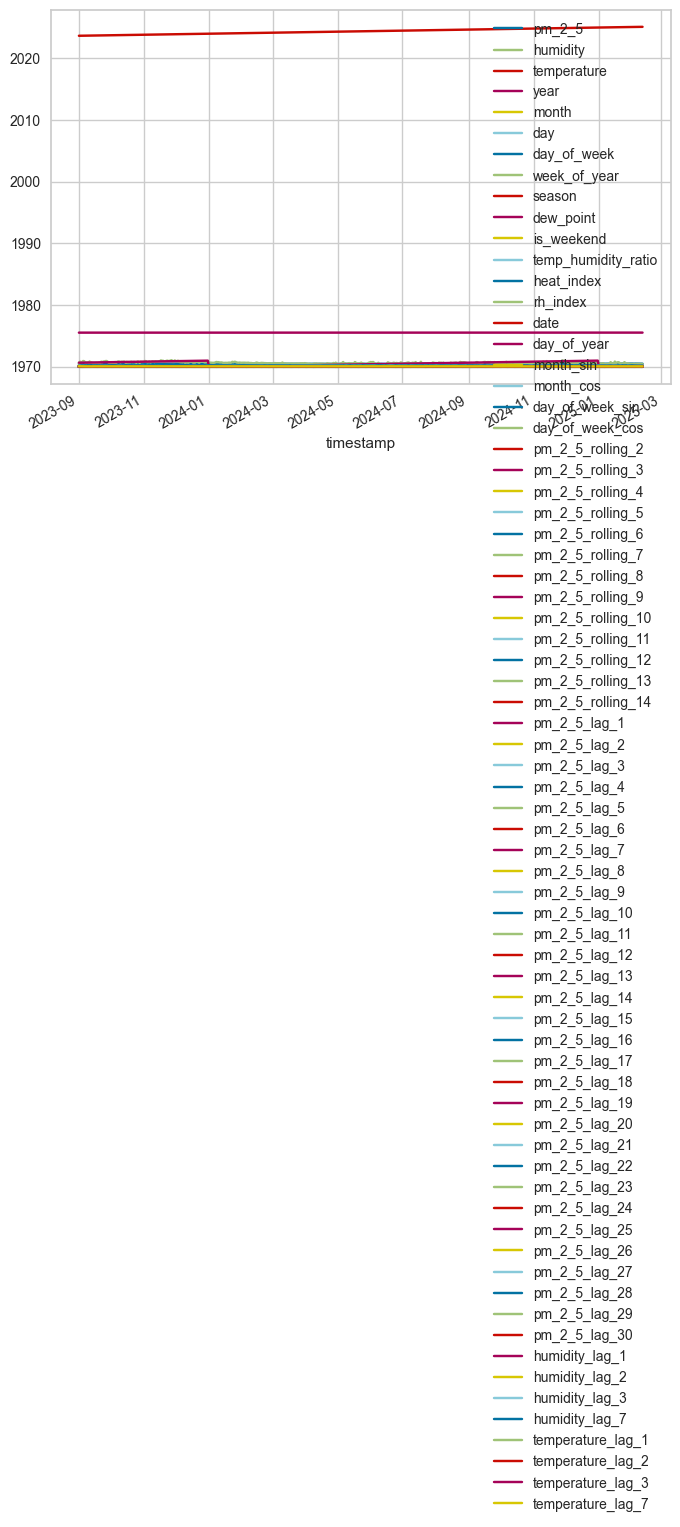

In [102]:
data_filtered.plot()

In [103]:
# สมมติว่า data มีจำนวนวันทั้งหมด
total_data = len(data_filtered)

# จำนวนวันที่ต้องการเป็น test data
test_days = 30

# คำนวณสัดส่วนของ 30 วันในข้อมูลทั้งหมด
test_size = test_days / total_data
test_size

0.05660377358490566

In [104]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_filtered, test_size=test_size, shuffle=False)

In [105]:
train_data.shape

(500, 71)

In [106]:
test_data.shape

(30, 71)

In [107]:
test_data.head(1)

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,pm_2_5_lag_29,pm_2_5_lag_30,humidity_lag_1,humidity_lag_2,humidity_lag_3,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-13 07:00:00,42.594631,78.292202,25.997341,2025,1,13,0,3,2,21.655782,...,9.330097,16.010753,85.379806,73.568381,70.491487,72.844643,25.434972,28.357459,28.945704,28.825509


In [108]:
test_data.tail(1)

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,pm_2_5_lag_29,pm_2_5_lag_30,humidity_lag_1,humidity_lag_2,humidity_lag_3,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-11 07:00:00,27.522727,68.159624,28.693799,2025,2,11,1,7,0,22.325724,...,42.594631,34.02521,71.226336,69.916384,69.348548,70.266522,28.251201,28.373742,28.385596,27.775432


In [109]:
test_data.tail()

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,pm_2_5_lag_29,pm_2_5_lag_30,humidity_lag_1,humidity_lag_2,humidity_lag_3,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-07 07:00:00,29.321219,70.933952,28.271927,2025,2,7,4,6,0,22.458717,...,33.810780,35.536756,69.511783,71.500943,70.266522,68.520368,28.579177,28.327450,27.775432,27.336718
2025-02-08 07:00:00,26.000000,69.348548,28.385596,2025,2,8,5,6,0,22.255305,...,37.291228,33.810780,70.933952,69.511783,71.500943,69.231031,28.271927,28.579177,28.327450,27.315410
2025-02-09 07:00:00,24.616898,69.916384,28.373742,2025,2,9,6,6,0,22.357019,...,40.511737,37.291228,69.348548,70.933952,69.511783,70.341639,28.385596,28.271927,28.579177,27.683890
2025-02-10 07:00:00,25.856981,71.226336,28.251201,2025,2,10,0,7,0,22.496468,...,34.025210,40.511737,69.916384,69.348548,70.933952,65.114261,28.373742,28.385596,28.271927,28.644544
2025-02-11 07:00:00,27.522727,68.159624,28.693799,2025,2,11,1,7,0,22.325724,...,42.594631,34.025210,71.226336,69.916384,69.348548,70.266522,28.251201,28.373742,28.385596,27.775432


In [110]:
test_data.columns

Index(['pm_2_5', 'humidity', 'temperature', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'season', 'dew_point', 'is_weekend',
       'temp_humidity_ratio', 'heat_index', 'rh_index', 'date', 'day_of_year',
       'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
       'pm_2_5_rolling_2', 'pm_2_5_rolling_3', 'pm_2_5_rolling_4',
       'pm_2_5_rolling_5', 'pm_2_5_rolling_6', 'pm_2_5_rolling_7',
       'pm_2_5_rolling_8', 'pm_2_5_rolling_9', 'pm_2_5_rolling_10',
       'pm_2_5_rolling_11', 'pm_2_5_rolling_12', 'pm_2_5_rolling_13',
       'pm_2_5_rolling_14', 'pm_2_5_lag_1', 'pm_2_5_lag_2', 'pm_2_5_lag_3',
       'pm_2_5_lag_4', 'pm_2_5_lag_5', 'pm_2_5_lag_6', 'pm_2_5_lag_7',
       'pm_2_5_lag_8', 'pm_2_5_lag_9', 'pm_2_5_lag_10', 'pm_2_5_lag_11',
       'pm_2_5_lag_12', 'pm_2_5_lag_13', 'pm_2_5_lag_14', 'pm_2_5_lag_15',
       'pm_2_5_lag_16', 'pm_2_5_lag_17', 'pm_2_5_lag_18', 'pm_2_5_lag_19',
       'pm_2_5_lag_20', 'pm_2_5_lag_21', 'pm_2_5_lag_22', 'pm_2_5

In [111]:
# train_data.dropna()

In [112]:
# from pycaret.time_series import *
from pycaret.regression import RegressionExperiment
exp1 = RegressionExperiment()
exp1.setup(data=train_data, target='pm_2_5', session_id=123, fold=12, iterative_imputation_iters=100, remove_outliers = True)
# iterative_imputation_iters=100, remove_outliers = True

,Description,Value
0,Session id,123
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(500, 71)"
4,Transformed data shape,"(482, 73)"
5,Transformed train set shape,"(332, 73)"
6,Transformed test set shape,"(150, 73)"
7,Numeric features,69
8,Date features,1
9,Preprocess,True


In [114]:
# compare baseline models
best = exp1.compare_models(n_select=15)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,5.1595,44.9801,6.5699,0.5168,0.3538,0.3348,0.2567
br,Bayesian Ridge,5.1981,46.1058,6.6448,0.5024,0.3532,0.3301,0.0825
huber,Huber Regressor,5.1993,46.6591,6.6766,0.5010,0.3513,0.3106,0.0950
et,Extra Trees Regressor,5.2772,47.5640,6.7213,0.5008,0.3525,0.3399,0.2667
llar,Lasso Least Angle Regression,5.2160,46.3843,6.6633,0.4975,0.3509,0.3294,0.0825
omp,Orthogonal Matching Pursuit,5.2183,46.3941,6.6682,0.4964,0.3525,0.3318,0.0792
lasso,Lasso Regression,5.2179,46.5413,6.6757,0.4945,0.3522,0.3297,0.0975
ada,AdaBoost Regressor,5.4321,48.3251,6.8064,0.4920,0.3643,0.3635,0.1675
lightgbm,Light Gradient Boosting Machine,5.3598,47.7076,6.7886,0.4909,0.3614,0.3415,0.2083
rf,Random Forest Regressor,5.3624,48.1669,6.7880,0.4904,0.3589,0.3495,0.3717


In [ ]:
# model_1 = exp1.create_model('rf')
model_1 = exp1.create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.2751,29.2687,5.4101,0.6781,0.3155,0.2924
1,7.4589,102.5610,10.1272,0.4350,0.4087,0.3495
2,4.3686,25.0092,5.0009,0.6583,0.3787,0.4239
3,6.2326,58.5038,7.6488,0.4792,0.4179,0.4467
4,4.4886,50.3249,7.0940,0.5159,0.2881,0.2198
5,5.3013,45.3702,6.7357,0.2437,0.4059,0.4214
6,5.4068,44.9082,6.7014,0.2663,0.3746,0.3776
7,5.9000,52.3102,7.2326,0.5883,0.3890,0.4082
8,4.5732,31.0164,5.5692,0.6000,0.2900,0.2787


In [ ]:
new_data = test_data.copy().drop(['pm_2_5'], axis=1)
predictions = exp1.predict_model(model_1, data=new_data)
predictions.head()

,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,is_weekend,...,pm_2_5_lag_14,humidity_lag_1,humidity_lag_2,humidity_lag_3,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_7,prediction_label
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-13 07:00:00,78.292206,25.997341,2025,1,13,0,3,2,21.655781,0,...,10.602564,85.379807,73.568382,70.491486,72.844643,25.434973,28.357460,28.945705,28.825508,29.148905
2025-01-14 07:00:00,74.887207,26.780884,2025,1,14,1,3,2,21.758324,0,...,23.222094,78.292206,85.379807,73.568382,70.630295,25.997341,25.434973,28.357460,29.145098,35.195877
2025-01-15 07:00:00,74.201401,27.146723,2025,1,15,2,3,2,21.987003,0,...,19.562716,74.887207,78.292206,85.379807,71.168640,26.780884,25.997341,25.434973,28.921543,37.269023
2025-01-16 07:00:00,89.873428,24.990604,2025,1,16,3,3,2,22.965288,0,...,26.081564,74.201401,74.887207,78.292206,70.983574,27.146723,26.780884,25.997341,28.383165,34.494715
2025-01-17 07:00:00,80.848938,27.221664,2025,1,17,4,3,2,23.391453,0,...,23.381714,89.873428,74.201401,74.887207,70.491486,24.990604,27.146723,26.780884,28.945705,36.374815


In [ ]:
predict_v = predictions['prediction_label']
predict_v.head()

timestamp
2025-01-13 07:00:00    29.148905
2025-01-14 07:00:00    35.195877
2025-01-15 07:00:00    37.269023
2025-01-16 07:00:00    34.494715
2025-01-17 07:00:00    36.374815
Freq: D, Name: prediction_label, dtype: float64

In [ ]:
real = test_data['pm_2_5']
# real.head(7)

# ทำนาย 1 วันข้างหน้า ต้องทำนายเผื่อ 2 วัน

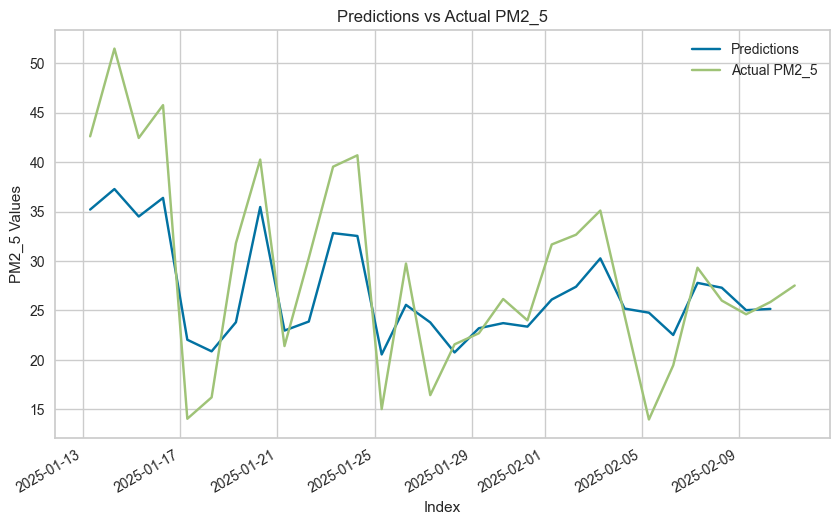

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result = pd.concat([predict_v.shift(-1), test_data['pm_2_5']], axis=1)
result.columns = ['Predictions', 'Actual PM2_5']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM2_5')
plt.xlabel('Index')
plt.ylabel('PM2_5 Values')

# แสดงกราฟ
plt.show()

In [ ]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_true = test_data["pm_2_5"][:"2025-2-10"]
y_pred = predict_v.shift(-1).dropna(axis=0)# "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = (1 - (mae / mean_actual)) * 100  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage

R² Score: 0.6345
Mean Absolute Error (MAE): 4.9238
Root Mean Squared Error (RMSE): 6.0355
Accuracy: 82.91%


# Predict 1 by 1

30 วัน  
2025-01-13 07:00:00  
2025-02-11 07:00:00  
7 วัน  
2025-02-05  
2025-02-11  
24 วัน  
2025-01-19 07:00:00  
31 วัน
2025-01-12 07:00:00

In [ ]:
# model_1 = exp1.create_model('rf')
# tune_1 = exp1.tune_model(model_1)

In [ ]:
model = exp1.create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.0125,38.6303,6.2153,0.5751,0.3471,0.3325
1,7.5967,109.6520,10.4715,0.3959,0.4106,0.3465
2,4.3346,26.9024,5.1868,0.6324,0.3449,0.3590
3,6.1966,55.5033,7.4501,0.5059,0.4106,0.4193
4,4.9207,43.6465,6.6065,0.5802,0.2795,0.2437
5,5.3706,46.2036,6.7973,0.2299,0.4150,0.4315
6,5.9676,52.2487,7.2283,0.1464,0.3848,0.4042
7,5.2017,41.6968,6.4573,0.6718,0.3800,0.3796
8,4.7358,34.6894,5.8898,0.5527,0.3102,0.2771


In [ ]:
data_compare = data_filtered.loc[:'2025-01-12']
result = pd.DataFrame()

start_date = "2025-01-13"
end_date = "2025-02-11"

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    # เพิ่มฟีเจอร์ rolling average (ค่าเฉลี่ยเคลื่อนที่)

    # data_compare['pm_2_5_rolling_7'] = data_compare['pm_2_5'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10

    # rolling_size = 1
    # for i in range(1,rolling_size+1):
    #     data_compare[f'pm_2_5_rolling_{i}'] = data_compare['pm_2_5'].rolling(window=i).mean().shift(1)

    for i in range(1,lag_size+1):
        data_compare[f'pm_2_5_lag_{i}'] = data_compare['pm_2_5'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['pm_2_5'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = exp1.predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'pm_2_5'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result
    result = pd.concat([result, predict_test_1], axis=0)

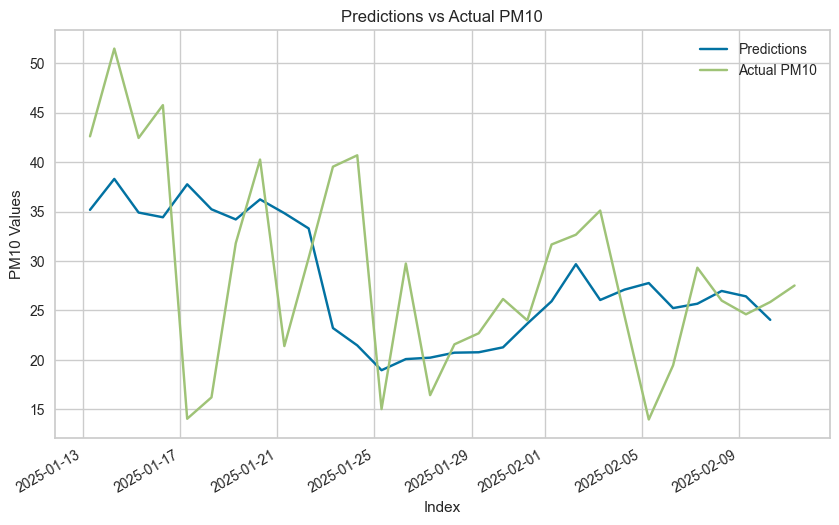

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['pm_2_5']], axis=1)
result_plot.columns = ['Predictions', 'Actual PM10']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result_plot.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM10')
plt.xlabel('Index')
plt.ylabel('PM10 Values')

# แสดงกราฟ
plt.show()

In [ ]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_true = real_data["pm_2_5"][:"2025-2-10"]
y_pred = result['prediction_label'].shift(-1).dropna(axis=0)# "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = (1 - (mae / mean_actual)) * 100  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage

R² Score: 0.0632
Mean Absolute Error (MAE): 7.3800
Root Mean Squared Error (RMSE): 9.6622
Accuracy: 74.38%


In [ ]:
# ค่า R² และ MAPE
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE in percentage

# การปรับสเกลของ R² (สมมติให้อยู่ในช่วง 0-100 เพื่อให้อยู่ในช่วงเดียวกับ MAPE)
r2_scaled = r2 * 100  # เปลี่ยน R² ให้เป็นค่าร้อยละ

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



R² Score: 0.0632
Mean Absolute Percentage Error (MAPE): 30.56%


Processing model: GradientBoostingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,11.6307,135.2729,11.6307,nan,0.3103,0.2731


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,14.7928,218.8273,14.7928,nan,0.3313,0.2875


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,10.0033,100.0669,10.0033,nan,0.2618,0.2358


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,16.1679,261.4000,16.1679,nan,0.4244,0.3534


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,14.7806,218.4660,14.7806,nan,0.6838,1.0512


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,22.2809,496.4385,22.2809,nan,0.8301,1.3734


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,3.1240,9.7594,3.1240,nan,0.1001,0.0982


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,8.1086,65.7496,8.1086,nan,0.2189,0.2015


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,15.1612,229.8630,15.1612,nan,0.5168,0.7083


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,10.2056,104.1537,10.2056,nan,0.2821,0.3367


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.5135,2.2907,1.5135,nan,0.0367,0.0383


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,4.3776,19.1632,4.3776,nan,0.1110,0.1076


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,21.7206,471.7847,21.7206,nan,0.8562,1.4443


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,6.6503,44.2270,6.6503,nan,0.1958,0.2236


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,20.5687,423.0704,20.5687,nan,0.7788,1.2505


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,10.9306,119.4791,10.9306,nan,0.3948,0.5065


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,6.9454,48.2392,6.9454,nan,0.2570,0.3060


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.8762,0.7677,0.8762,nan,0.0328,0.0335


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.1189,0.0141,0.1189,nan,0.0048,0.0050


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,8.1869,67.0254,8.1869,nan,0.2885,0.2585


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,5.2779,27.8560,5.2779,nan,0.1706,0.1616


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,9.7093,94.2710,9.7093,nan,0.3133,0.2767


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2.9329,8.6022,2.9329,nan,0.1090,0.1199


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,13.4342,180.4787,13.4342,nan,0.6400,0.9605


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,9.0694,82.2532,9.0694,nan,0.3670,0.4662


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.9592,0.9202,0.9592,nan,0.0311,0.0327


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.2189,1.4858,1.2189,nan,0.0442,0.0469


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.9831,3.9327,1.9831,nan,0.0746,0.0806


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,4.5575,20.7706,4.5575,nan,0.1860,0.1763


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,9.4401,89.1163,9.4401,nan,0.4019,0.3430


Processing model: BayesianRidge


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,15.5305,241.1959,15.5305,nan,0.4404,0.3646


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,26.5223,703.4318,26.5223,nan,0.7043,0.5154


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,15.4100,237.4681,15.4100,nan,0.4382,0.3632


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,20.6480,426.3409,20.6480,nan,0.5828,0.4513


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,10.6783,114.0257,10.6783,nan,0.5359,0.7594


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,10.5538,111.3820,10.5538,nan,0.4780,0.6505


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,5.5899,31.2474,5.5899,nan,0.1869,0.1758


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,17.2788,298.5561,17.2788,nan,0.5429,0.4293


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.5032,12.2727,3.5032,nan,0.1453,0.1637


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.5393,2.3693,1.5393,nan,0.0504,0.0508


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,11.8823,141.1902,11.8823,nan,0.3470,0.3006


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,13.6567,186.5066,13.6567,nan,0.3970,0.3357


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,12.5426,157.3174,12.5426,nan,0.5778,0.8340


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.2154,4.9078,2.2154,nan,0.0748,0.0745


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,9.6929,93.9523,9.6929,nan,0.4418,0.5893


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,4.0546,16.4399,4.0546,nan,0.1651,0.1879


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.1218,9.7458,3.1218,nan,0.1238,0.1375


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.1073,4.4408,2.1073,nan,0.0808,0.0806


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.6304,0.3973,0.6304,nan,0.0255,0.0263


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,6.9379,48.1350,6.9379,nan,0.2387,0.2191


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,5.6335,31.7359,5.6335,nan,0.1832,0.1725


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,8.8896,79.0254,8.8896,nan,0.2827,0.2533


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.2135,0.0456,0.2135,nan,0.0084,0.0087


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,11.1619,124.5870,11.1619,nan,0.5566,0.7980


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,5.9558,35.4710,5.9558,nan,0.2555,0.3061


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,4.9803,24.8031,4.9803,nan,0.1794,0.1699


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.4478,5.9916,2.4478,nan,0.0950,0.0941


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.9214,0.8489,0.9214,nan,0.0366,0.0374


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.6387,6.9627,2.6387,nan,0.1034,0.1020


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,4.5120,20.3579,4.5120,nan,0.1722,0.1639


Processing model: HuberRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,15.0138,225.4146,15.0138,nan,0.4222,0.3525


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,26.1316,682.8620,26.1316,nan,0.6894,0.5078


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,16.5294,273.2207,16.5294,nan,0.4790,0.3896


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,20.3163,412.7540,20.3163,nan,0.5702,0.4441


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,11.3071,127.8514,11.3071,nan,0.5600,0.8041


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,11.0101,121.2229,11.0101,nan,0.4942,0.6787


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,4.6907,22.0029,4.6907,nan,0.1543,0.1475


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,16.9545,287.4557,16.9545,nan,0.5294,0.4213


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.1343,4.5554,2.1343,nan,0.0910,0.0997


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,5.1465,26.4869,5.1465,nan,0.1796,0.1698


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,15.1202,228.6198,15.1202,nan,0.4669,0.3825


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,17.3489,300.9848,17.3489,nan,0.5383,0.4265


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,10.3188,106.4773,10.3188,nan,0.4968,0.6862


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,3.4977,12.2340,3.4977,nan,0.1208,0.1176


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,9.0410,81.7389,9.0410,nan,0.4175,0.5497


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,3.3188,11.0147,3.3188,nan,0.1371,0.1538


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.6845,7.2064,2.6845,nan,0.1073,0.1183


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.9393,8.6397,2.9393,nan,0.1145,0.1124


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,1.9516,3.8087,1.9516,nan,0.0813,0.0813


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,8.0717,65.1527,8.0717,nan,0.2838,0.2549


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,6.5758,43.2408,6.5758,nan,0.2174,0.2014


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,8.4961,72.1842,8.4961,nan,0.2684,0.2421


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.6673,0.4453,0.6673,nan,0.0259,0.0273


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,11.8008,139.2581,11.8008,nan,0.5808,0.8437


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,5.2436,27.4957,5.2436,nan,0.2282,0.2695


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,6.8503,46.9272,6.8503,nan,0.2561,0.2336


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,5.3491,28.6124,5.3491,nan,0.2208,0.2057


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,4.3413,18.8468,4.3413,nan,0.1857,0.1764


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,6.2535,39.1064,6.2535,nan,0.2651,0.2419


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,7.6279,58.1843,7.6279,nan,0.3112,0.2771


Processing model: ExtraTreesRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,10.9532,119.9733,10.9532,nan,0.2894,0.2572


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,24.1365,582.5695,24.1365,nan,0.6163,0.4690


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,16.2621,264.4550,16.2621,nan,0.4691,0.3833


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,23.2640,541.2114,23.2640,nan,0.6885,0.5085


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,11.0269,121.5917,11.0269,nan,0.5494,0.7842


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,10.4249,108.6793,10.4249,nan,0.4733,0.6426


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,10.1214,102.4425,10.1214,nan,0.3690,0.3183


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,18.7705,352.3317,18.7705,nan,0.6071,0.4664


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,4.1826,17.4939,4.1826,nan,0.1712,0.1954


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,5.6466,31.8842,5.6466,nan,0.1989,0.1863


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,15.5910,243.0795,15.5910,nan,0.4856,0.3944


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,16.6236,276.3425,16.6236,nan,0.5089,0.4087


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,6.9236,47.9369,6.9236,nan,0.3589,0.4604


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,7.2830,53.0425,7.2830,nan,0.2704,0.2449


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,5.9575,35.4921,5.9575,nan,0.2938,0.3622


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.6994,0.4892,0.6994,nan,0.0305,0.0324


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.5120,0.2621,0.5120,nan,0.0218,0.0226


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,4.3917,19.2869,4.3917,nan,0.1764,0.1679


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.7804,3.1696,1.7804,nan,0.0739,0.0742


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,4.3692,19.0895,4.3692,nan,0.1436,0.1380


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,5.8079,33.7317,5.8079,nan,0.1894,0.1779


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,7.9309,62.8994,7.9309,nan,0.2481,0.2260


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.1500,1.3225,1.1500,nan,0.0442,0.0470


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,11.4832,131.8636,11.4832,nan,0.5688,0.8210


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,7.3194,53.5736,7.3194,nan,0.3059,0.3762


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.6167,2.6138,1.6167,nan,0.0548,0.0551


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.3716,1.8812,1.3716,nan,0.0496,0.0528


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.2360,4.9998,2.2360,nan,0.0837,0.0908


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.7783,0.6057,0.7783,nan,0.0286,0.0301


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.8927,3.5824,1.8927,nan,0.0687,0.0688


Processing model: LassoLars


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,14.7843,218.5751,14.7843,nan,0.4142,0.3471


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,25.9413,672.9504,25.9413,nan,0.6822,0.5041


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,15.1290,228.8855,15.1290,nan,0.4282,0.3566


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,20.2765,411.1363,20.2765,nan,0.5687,0.4432


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,11.2839,127.3257,11.2839,nan,0.5592,0.8025


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,10.5751,111.8334,10.5751,nan,0.4787,0.6519


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,5.2632,27.7014,5.2632,nan,0.1749,0.1655


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,16.2570,264.2907,16.2570,nan,0.5011,0.4039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,4.0613,16.4938,4.0613,nan,0.1666,0.1897


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.3741,1.8883,1.3741,nan,0.0449,0.0453


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,11.2919,127.5059,11.2919,nan,0.3266,0.2857


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,13.3169,177.3398,13.3169,nan,0.3850,0.3274


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,11.9251,142.2082,11.9251,nan,0.5559,0.7930


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.8044,3.2558,1.8044,nan,0.0605,0.0607


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,10.7816,116.2437,10.7816,nan,0.4812,0.6555


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,5.3956,29.1124,5.3956,nan,0.2143,0.2500


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,3.9133,15.3143,3.9133,nan,0.1528,0.1724


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,0.2993,0.0896,0.2993,nan,0.0111,0.0114


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.1276,1.2715,1.1276,nan,0.0441,0.0470


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,6.5730,43.2039,6.5730,nan,0.2246,0.2075


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,6.2950,39.6272,6.2950,nan,0.2071,0.1928


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,8.7116,75.8922,8.7116,nan,0.2762,0.2482


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,0.4862,0.2364,0.4862,nan,0.0189,0.0199


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,10.9159,119.1579,10.9159,nan,0.5472,0.7804


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,6.1129,37.3674,6.1129,nan,0.2615,0.3142


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,4.2698,18.2310,4.2698,nan,0.1518,0.1456


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.7789,3.1646,1.7789,nan,0.0682,0.0684


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,0.6764,0.4575,0.6764,nan,0.0268,0.0275


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.8955,3.5929,1.8955,nan,0.0732,0.0733


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,3.3096,10.9538,3.3096,nan,0.1233,0.1203


Processing model: OrthogonalMatchingPursuit


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,14.0448,197.2556,14.0448,nan,0.3889,0.3297


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,25.1353,631.7855,25.1353,nan,0.6523,0.4884


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,13.3753,178.8998,13.3753,nan,0.3681,0.3152


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,17.2862,298.8112,17.2862,nan,0.4617,0.3779


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,14.8613,220.8579,14.8613,nan,0.6865,1.0569


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,12.8041,163.9458,12.8041,nan,0.5559,0.7893


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.4204,5.8583,2.4204,nan,0.0767,0.0761


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,12.7006,161.3041,12.7006,nan,0.3681,0.3156


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,3.4636,11.9967,3.4636,nan,0.1437,0.1618


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.8106,7.8993,2.8106,nan,0.0940,0.0927


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,9.3655,87.7126,9.3655,nan,0.2628,0.2369


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,11.2079,125.6171,11.2079,nan,0.3132,0.2755


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,14.6646,215.0513,14.6646,nan,0.6494,0.9751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.5792,2.4939,1.5792,nan,0.0501,0.0531


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,14.6012,213.1959,14.6012,nan,0.6081,0.8877


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,7.3906,54.6204,7.3906,nan,0.2831,0.3425


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,4.8145,23.1791,4.8145,nan,0.1850,0.2121


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.4947,2.2341,1.4947,nan,0.0536,0.0571


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,4.3563,18.9775,4.3563,nan,0.1606,0.1815


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,3.4037,11.5851,3.4037,nan,0.1100,0.1075


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,3.9752,15.8022,3.9752,nan,0.1257,0.1217


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,5.2406,27.4641,5.2406,nan,0.1569,0.1493


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,4.3097,18.5736,4.3097,nan,0.1564,0.1762


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,13.3960,179.4515,13.3960,nan,0.6386,0.9577


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,7.6754,58.9115,7.6754,nan,0.3186,0.3945


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.9378,3.7550,1.9378,nan,0.0660,0.0661


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.1985,1.4363,1.1985,nan,0.0434,0.0461


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.5654,6.5812,2.5654,nan,0.0954,0.1042


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.8929,3.5831,1.8929,nan,0.0681,0.0732


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.9446,0.8922,0.9446,nan,0.0326,0.0343


Processing model: Lasso


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,14.7849,218.5937,14.7849,nan,0.4142,0.3471


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,25.9441,673.0987,25.9441,nan,0.6823,0.5042


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,15.1319,228.9749,15.1319,nan,0.4284,0.3566


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,20.2819,411.3543,20.2819,nan,0.5689,0.4433


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,11.2797,127.2326,11.2797,nan,0.5590,0.8022


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,10.5708,111.7416,10.5708,nan,0.4786,0.6516


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,5.2685,27.7576,5.2685,nan,0.1751,0.1657


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,16.2632,264.4908,16.2632,nan,0.5014,0.4041


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,4.0579,16.4663,4.0579,nan,0.1664,0.1896


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.3785,1.9003,1.3785,nan,0.0450,0.0455


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,11.2945,127.5662,11.2945,nan,0.3267,0.2857


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,13.3186,177.3842,13.3186,nan,0.3850,0.3274


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,11.9228,142.1529,11.9228,nan,0.5558,0.7928


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.8068,3.2645,1.8068,nan,0.0606,0.0607


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,10.7769,116.1425,10.7769,nan,0.4810,0.6552


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,5.3905,29.0580,5.3905,nan,0.2141,0.2498


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,3.9068,15.2634,3.9068,nan,0.1526,0.1721


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.3069,0.0942,0.3069,nan,0.0114,0.0117


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.1190,1.2522,1.1190,nan,0.0438,0.0466


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,6.5762,43.2468,6.5762,nan,0.2248,0.2077


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,6.2972,39.6551,6.2972,nan,0.2072,0.1928


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,8.7157,75.9627,8.7157,nan,0.2764,0.2483


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.4819,0.2322,0.4819,nan,0.0188,0.0197


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,10.9126,119.0858,10.9126,nan,0.5470,0.7802


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,6.1093,37.3240,6.1093,nan,0.2613,0.3140


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,4.2735,18.2624,4.2735,nan,0.1519,0.1457


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.7818,3.1748,1.7818,nan,0.0683,0.0685


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.6788,0.4608,0.6788,nan,0.0269,0.0276


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.8994,3.6078,1.8994,nan,0.0733,0.0735


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,3.3144,10.9853,3.3144,nan,0.1235,0.1204


Processing model: AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,10.4872,109.9809,10.4872,nan,0.2752,0.2462


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,20.5311,421.5264,20.5311,nan,0.4965,0.3990


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,18.0546,325.9678,18.0546,nan,0.5374,0.4255


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,21.3717,456.7495,21.3717,nan,0.6110,0.4672


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,11.2769,127.1695,11.2769,nan,0.5589,0.8020


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,8.6557,74.9207,8.6557,nan,0.4072,0.5335


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,9.7048,94.1836,9.7048,nan,0.3508,0.3052


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,18.1518,329.4861,18.1518,nan,0.5800,0.4510


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,2.5722,6.6163,2.5722,nan,0.1087,0.1202


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,5.4329,29.5169,5.4329,nan,0.1906,0.1792


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,15.1172,228.5306,15.1172,nan,0.4668,0.3824


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,16.9649,287.8094,16.9649,nan,0.5226,0.4171


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,7.6009,57.7742,7.6009,nan,0.3879,0.5054


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,6.7829,46.0078,6.7829,nan,0.2493,0.2280


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,8.4310,71.0824,8.4310,nan,0.3942,0.5126


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.1656,0.0274,0.1656,nan,0.0073,0.0077


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,1.8082,3.2697,1.8082,nan,0.0794,0.0797


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,9.0439,81.7915,9.0439,nan,0.4049,0.3457


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,6.8863,47.4215,6.8863,nan,0.3222,0.2869


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,14.4547,208.9390,14.4547,nan,0.5842,0.4564


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,15.5381,241.4332,15.5381,nan,0.6193,0.4758


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,15.3597,235.9211,15.3597,nan,0.5543,0.4377


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,7.1762,51.4986,7.1762,nan,0.3311,0.2934


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,5.7478,33.0378,5.7478,nan,0.3246,0.4109


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.4727,0.2234,0.4727,nan,0.0228,0.0243


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,9.3937,88.2409,9.3937,nan,0.3708,0.3204


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,6.1539,37.8705,6.1539,nan,0.2587,0.2367


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,4.6893,21.9899,4.6893,nan,0.2022,0.1905


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,6.0109,36.1307,6.0109,nan,0.2534,0.2325


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,7.5952,57.6866,7.5952,nan,0.3096,0.2760


Processing model: LGBMRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,9.1095,82.9825,9.1095,nan,0.2344,0.2139


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,20.3776,415.2479,20.3776,nan,0.4917,0.3960


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,13.4463,180.8040,13.4463,nan,0.3705,0.3169


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,20.1778,407.1421,20.1778,nan,0.5650,0.4411


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,16.3937,268.7541,16.3937,nan,0.7364,1.1659


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,12.4924,156.0591,12.4924,nan,0.5454,0.7700


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,8.6593,74.9836,8.6593,nan,0.3065,0.2723


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,17.7226,314.0900,17.7226,nan,0.5616,0.4404


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.4409,5.9581,2.4409,nan,0.1034,0.1140


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,4.3517,18.9371,4.3517,nan,0.1496,0.1436


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,13.7529,189.1409,13.7529,nan,0.4145,0.3479


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,14.0399,197.1193,14.0399,nan,0.4108,0.3451


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,10.2795,105.6671,10.2795,nan,0.4953,0.6835


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.6628,13.4159,3.6628,nan,0.1269,0.1231


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,7.2509,52.5763,7.2509,nan,0.3475,0.4408


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.4041,11.5882,3.4041,nan,0.1634,0.1577


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.7653,14.1777,3.7653,nan,0.1730,0.1659


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,10.1401,102.8224,10.1401,nan,0.4673,0.3876


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,9.6949,93.9915,9.6949,nan,0.4906,0.4039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,15.3584,235.8798,15.3584,nan,0.6351,0.4850


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,13.2957,176.7765,13.2957,nan,0.5026,0.4072


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,15.8355,250.7638,15.8355,nan,0.5775,0.4512


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,4.2041,17.6747,4.2041,nan,0.1805,0.1719


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,11.1018,123.2509,11.1018,nan,0.5543,0.7937


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,8.9437,79.9905,8.9437,nan,0.3627,0.4597


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2450,0.0600,0.2450,nan,0.0081,0.0084


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.4000,5.7600,2.4000,nan,0.0852,0.0923


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.1851,1.4046,1.1851,nan,0.0452,0.0481


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1280,0.0164,0.1280,nan,0.0048,0.0050


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.7002,7.2909,2.7002,nan,0.0995,0.0981


Processing model: RandomForestRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,10.0283,100.5673,10.0283,nan,0.2614,0.2354


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,14.7350,217.1193,14.7350,nan,0.3297,0.2863


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,7.2152,52.0597,7.2152,nan,0.1817,0.1700


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,12.2408,149.8381,12.2408,nan,0.3036,0.2676


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,18.4935,342.0099,18.4935,nan,0.8011,1.3152


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,19.8710,394.8554,19.8710,nan,0.7672,1.2249


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.4394,5.9505,2.4394,nan,0.0717,0.0767


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,7.2940,53.2022,7.2940,nan,0.1946,0.1812


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,14.1107,199.1119,14.1107,nan,0.4884,0.6592


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,4.1378,17.1211,4.1378,nan,0.1241,0.1365


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,6.6219,43.8501,6.6219,nan,0.1784,0.1675


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,12.6257,159.4094,12.6257,nan,0.3609,0.3104


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,10.2403,104.8642,10.2403,nan,0.4938,0.6809


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,5.2949,28.0358,5.2949,nan,0.1890,0.1780


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,6.9399,48.1616,6.9399,nan,0.3349,0.4219


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.7047,0.4966,0.7047,nan,0.0307,0.0327


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.5570,0.3103,0.5570,nan,0.0232,0.0245


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.9247,8.5540,2.9247,nan,0.1139,0.1118


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.1907,0.0364,0.1907,nan,0.0077,0.0079


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,6.5003,42.2545,6.5003,nan,0.2219,0.2053


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,7.4221,55.0874,7.4221,nan,0.2491,0.2273


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,9.9987,99.9743,9.9987,nan,0.3244,0.2849


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.1662,0.0276,0.1662,nan,0.0065,0.0068


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,10.1483,102.9876,10.1483,nan,0.5171,0.7255


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,5.1469,26.4909,5.1469,nan,0.2244,0.2646


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,4.1030,16.8342,4.1030,nan,0.1454,0.1399


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.9217,0.8495,0.9217,nan,0.0347,0.0354


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.4315,0.1862,0.4315,nan,0.0170,0.0175


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.8148,3.2934,1.8148,nan,0.0700,0.0702


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.8561,3.4450,1.8561,nan,0.0673,0.0674


Processing model: ElasticNet


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,16.0848,258.7217,16.0848,nan,0.4604,0.3776


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,27.6077,762.1863,27.6077,nan,0.7471,0.5365


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,16.0696,258.2332,16.0696,nan,0.4621,0.3787


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,21.2122,449.9595,21.2122,nan,0.6047,0.4637


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,9.3235,86.9284,9.3235,nan,0.4818,0.6631


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,9.4951,90.1577,9.4951,nan,0.4391,0.5853


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,6.1170,37.4172,6.1170,nan,0.2064,0.1924


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,17.9916,323.6974,17.9916,nan,0.5731,0.4470


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.4645,6.0739,2.4645,nan,0.1044,0.1151


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.6122,2.5991,1.6122,nan,0.0529,0.0532


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,11.9518,142.8464,11.9518,nan,0.3494,0.3024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,13.9336,194.1441,13.9336,nan,0.4069,0.3425


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,11.9346,142.4350,11.9346,nan,0.5562,0.7936


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.3983,5.7519,2.3983,nan,0.0812,0.0806


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,9.5469,91.1436,9.5469,nan,0.4364,0.5804


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.6660,13.4398,3.6660,nan,0.1504,0.1699


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.6456,6.9995,2.6456,nan,0.1058,0.1166


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.1705,4.7111,2.1705,nan,0.0833,0.0830


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.1202,1.2548,1.1202,nan,0.0458,0.0467


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,8.1267,66.0440,8.1267,nan,0.2860,0.2566


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,6.8010,46.2536,6.8010,nan,0.2257,0.2083


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,10.0438,100.8771,10.0438,nan,0.3261,0.2862


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.2881,1.6592,1.2881,nan,0.0519,0.0527


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,9.6695,93.4993,9.6695,nan,0.4979,0.6913


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,4.9751,24.7516,4.9751,nan,0.2177,0.2557


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,5.7692,33.2834,5.7692,nan,0.2111,0.1968


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.6078,13.0165,3.6078,nan,0.1434,0.1388


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.1263,4.5210,2.1263,nan,0.0867,0.0864


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.3644,11.3194,3.3644,nan,0.1338,0.1301


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,5.3576,28.7037,5.3576,nan,0.2081,0.1947


Processing model: Ridge


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,19.3195,373.2414,19.3195,nan,0.5855,0.4536


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,29.8752,892.5272,29.8752,nan,0.8428,0.5805


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,16.4243,269.7589,16.4243,nan,0.4751,0.3871


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,19.7537,390.2075,19.7537,nan,0.5492,0.4318


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,10.8992,118.7933,10.8992,nan,0.5445,0.7751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,11.0328,121.7226,11.0328,nan,0.4950,0.6801


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,6.2610,39.2001,6.2610,nan,0.2118,0.1969


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,17.6758,312.4324,17.6758,nan,0.5596,0.4392


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.0209,4.0841,2.0209,nan,0.0864,0.0944


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.0802,0.0064,0.0802,nan,0.0026,0.0026


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,10.8627,117.9983,10.8627,nan,0.3120,0.2748


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,13.0907,171.3664,13.0907,nan,0.3770,0.3218


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,13.5092,182.4984,13.5092,nan,0.6110,0.8983


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.3621,11.3039,3.3621,nan,0.1158,0.1130


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,7.0995,50.4032,7.0995,nan,0.3414,0.4316


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.1375,1.2939,1.1375,nan,0.0517,0.0527


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.5943,0.3532,0.5943,nan,0.0254,0.0262


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,4.3850,19.2280,4.3850,nan,0.1761,0.1676


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.6250,2.6407,1.6250,nan,0.0672,0.0677


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,6.0486,36.5860,6.0486,nan,0.2047,0.1910


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.1408,9.8645,3.1408,nan,0.0980,0.0962


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,7.5519,57.0307,7.5519,nan,0.2347,0.2152


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.5467,2.3922,1.5467,nan,0.0590,0.0632


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,14.2490,203.0350,14.2490,nan,0.6682,1.0187


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,9.7993,96.0270,9.7993,nan,0.3914,0.5037


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.0539,0.0029,0.0539,nan,0.0018,0.0018


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.9736,3.8949,1.9736,nan,0.0705,0.0759


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.3691,11.3510,3.3691,nan,0.1236,0.1369


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.2530,5.0759,2.2530,nan,0.0806,0.0871


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.7033,2.9013,1.7033,nan,0.0616,0.0619


Processing model: LinearRegression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,15.7766,248.9021,15.7766,nan,0.4493,0.3704


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,24.0962,580.6250,24.0962,nan,0.6149,0.4682


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,18.0578,326.0833,18.0578,nan,0.5375,0.4256


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,24.0404,577.9401,24.0404,nan,0.7221,0.5255


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,4.8643,23.6615,4.8643,nan,0.2799,0.3459


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,4.2517,18.0766,4.2517,nan,0.2206,0.2621


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,14.1847,201.2061,14.1847,nan,0.5665,0.4461


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,27.0470,731.5405,27.0470,nan,1.0664,0.6721


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,7.5785,57.4329,7.5785,nan,0.4128,0.3540


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,5.1649,26.6761,5.1649,nan,0.1803,0.1704


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,12.1392,147.3606,12.1392,nan,0.3560,0.3071


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,12.7306,162.0679,12.7306,nan,0.3645,0.3130


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,12.2666,150.4699,12.2666,nan,0.5680,0.8157


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,5.4012,29.1733,5.4012,nan,0.1932,0.1816


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,4.2509,18.0697,4.2509,nan,0.2180,0.2584


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.8690,0.7551,0.8690,nan,0.0378,0.0403


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.4090,0.1673,0.4090,nan,0.0171,0.0180


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,5.2069,27.1118,5.2069,nan,0.2128,0.1990


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0060,0.0000,0.0060,nan,0.0002,0.0002


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,5.0238,25.2382,5.0238,nan,0.1670,0.1586


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.5469,6.4865,2.5469,nan,0.0787,0.0780


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,8.2560,68.1623,8.2560,nan,0.2597,0.2353


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.8795,3.5326,1.8795,nan,0.0712,0.0768


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,16.1900,262.1153,16.1900,nan,0.7325,1.1575


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,12.9342,167.2937,12.9342,nan,0.4900,0.6648


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.5729,6.6196,2.5729,nan,0.0814,0.0877


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,6.3467,40.2812,6.3467,nan,0.2111,0.2441


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,5.5692,31.0164,5.5692,nan,0.1967,0.2262


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.6614,0.4374,0.6614,nan,0.0243,0.0256


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,5.0613,25.6169,5.0613,nan,0.1953,0.1839


Processing model: KNeighborsRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,19.2129,369.1372,19.2129,nan,0.5811,0.4511


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,24.0046,576.2219,24.0046,nan,0.6117,0.4665


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,18.1572,329.6854,18.1572,nan,0.5414,0.4279


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,29.8685,892.1293,29.8685,nan,1.0187,0.6529


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,11.3716,129.3140,11.3716,nan,0.5625,0.8087


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,9.2095,84.8146,9.2095,nan,0.4283,0.5677


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,11.6263,135.1718,11.6263,nan,0.4377,0.3656


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,20.0733,402.9363,20.0733,nan,0.6669,0.4988


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,5.5378,30.6676,5.5378,nan,0.2839,0.2587


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,14.4433,208.6092,14.4433,nan,0.6185,0.4765


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,28.4018,806.6615,28.4018,nan,1.2066,0.7185


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,28.0611,787.4258,28.0611,nan,1.1187,0.6898


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,4.8403,23.4286,4.8403,nan,0.2637,0.3219


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,12.4636,155.3419,12.4636,nan,0.5199,0.4190


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.1251,0.0157,0.1251,nan,0.0071,0.0076


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,5.0072,25.0722,5.0072,nan,0.2507,0.2320


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,6.1248,37.5133,6.1248,nan,0.2990,0.2698


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,9.5880,91.9305,9.5880,nan,0.4354,0.3665


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,7.4305,55.2123,7.4305,nan,0.3527,0.3096


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,10.7021,114.5345,10.7021,nan,0.3969,0.3379


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,6.9905,48.8675,6.9905,nan,0.2328,0.2141


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,4.7739,22.7901,4.7739,nan,0.1419,0.1360


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,3.2388,10.4896,3.2388,nan,0.1197,0.1324


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,13.9142,193.6062,13.9142,nan,0.6567,0.9948


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,7.3363,53.8219,7.3363,nan,0.3065,0.3771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.9964,3.9855,1.9964,nan,0.0638,0.0681


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,6.2461,39.0135,6.2461,nan,0.2081,0.2402


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,6.6495,44.2158,6.6495,nan,0.2308,0.2701


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,5.4094,29.2617,5.4094,nan,0.1835,0.2092


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,3.2237,10.3924,3.2237,nan,0.1071,0.1171


Processing model: DecisionTreeRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,8.7839,77.1560,8.7839,nan,0.2250,0.2062


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,17.6498,311.5164,17.6498,nan,0.4101,0.3430


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.1404,0.0197,0.1404,nan,0.0032,0.0033


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,3.1767,10.0915,3.1767,nan,0.0704,0.0694


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,28.5096,812.7996,28.5096,nan,1.0623,2.0276


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,17.5876,309.3250,17.5876,nan,0.7037,1.0841


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,7.0609,49.8564,7.0609,nan,0.1950,0.2221


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.2098,1.4637,1.2098,nan,0.0289,0.0301


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,12.4045,153.8715,12.4045,nan,0.4406,0.5795


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,3.4990,12.2431,3.4990,nan,0.1059,0.1154


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.9271,3.7137,1.9271,nan,0.0465,0.0488


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,21.0686,443.8850,21.0686,nan,0.7042,0.5179


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,25.5479,652.6939,25.5479,nan,0.9528,1.6988


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,7.0257,49.3606,7.0257,nan,0.2595,0.2362


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,6.2702,39.3152,6.2702,nan,0.3070,0.3812


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,3.7148,13.8001,3.7148,nan,0.1523,0.1721


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.0202,0.0004,0.0202,nan,0.0009,0.0009


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,3.4430,11.8542,3.4430,nan,0.1355,0.1316


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,13.1299,172.3943,13.1299,nan,0.7447,0.5470


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,22.9060,524.6831,22.9060,nan,1.2078,0.7233


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,23.8914,570.8013,23.8914,nan,1.2375,0.7316


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,26.3309,693.3162,26.3309,nan,1.3075,0.7503


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,15.6954,246.3458,15.6954,nan,0.9584,0.6417


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,3.9129,15.3104,3.9129,nan,0.3026,0.2797


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,6.9786,48.7014,6.9786,nan,0.4173,0.3587


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,11.0747,122.6501,11.0747,nan,0.4545,0.3777


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,12.9521,167.7570,12.9521,nan,0.6534,0.4982


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,11.5690,133.8418,11.5690,nan,0.6008,0.4700


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,12.8091,164.0726,12.8091,nan,0.6481,0.4954


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,14.4748,209.5207,14.4748,nan,0.7082,0.5259


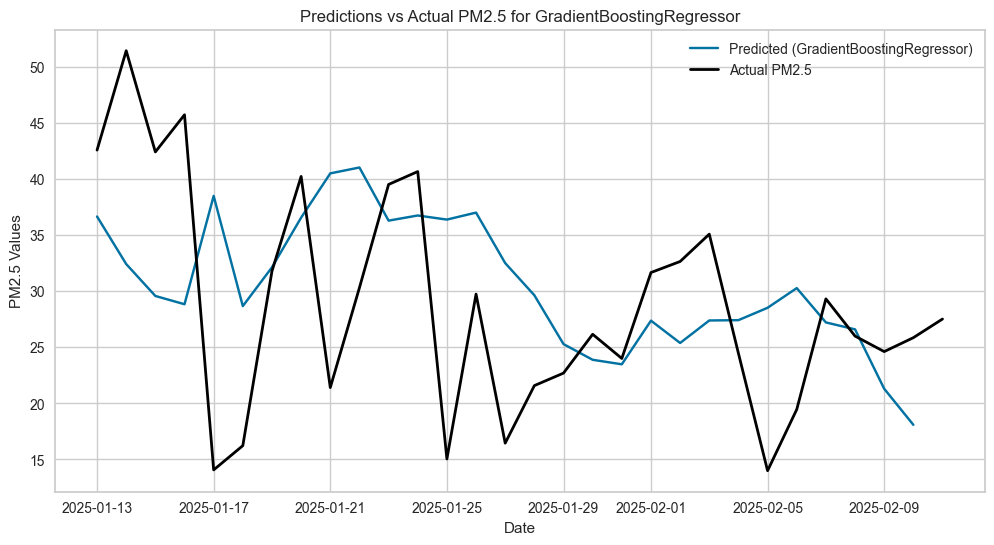

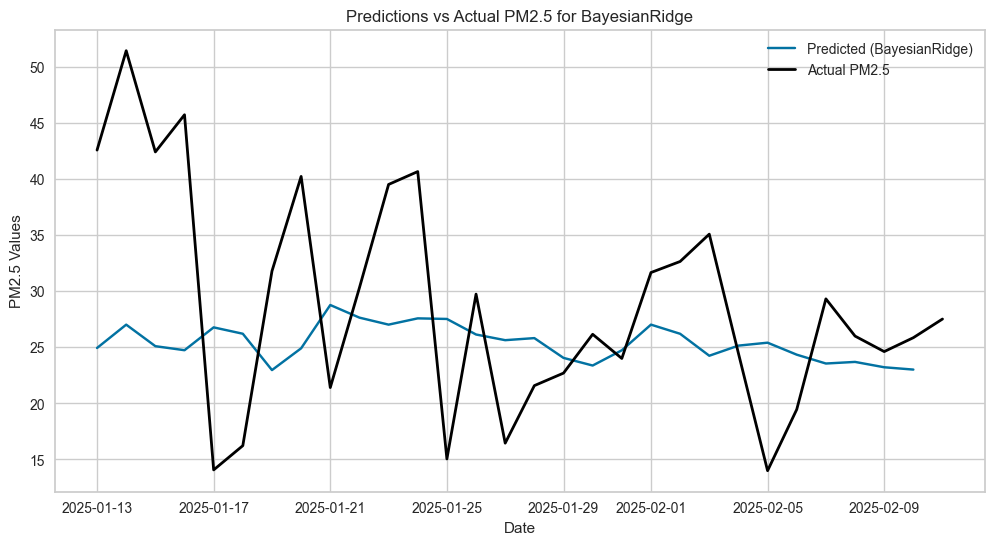

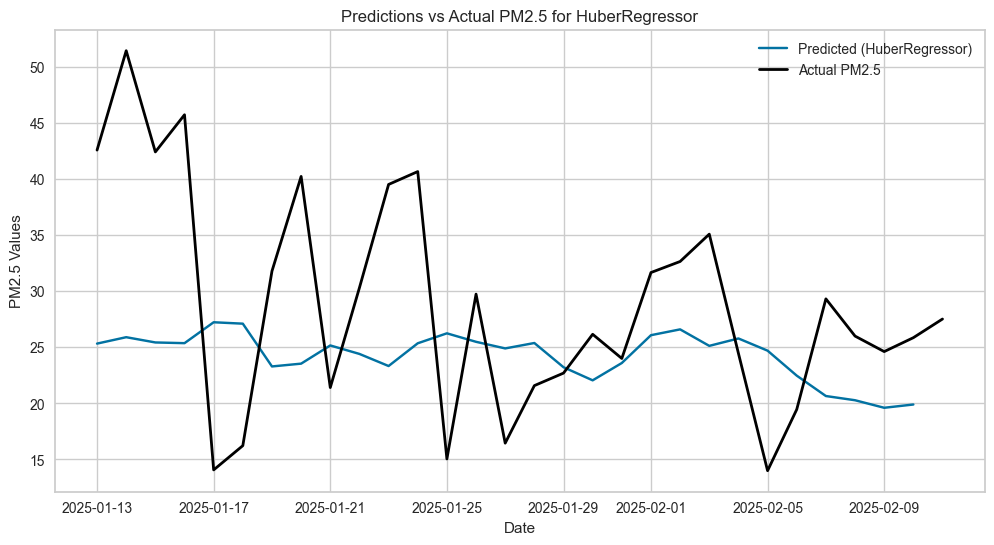

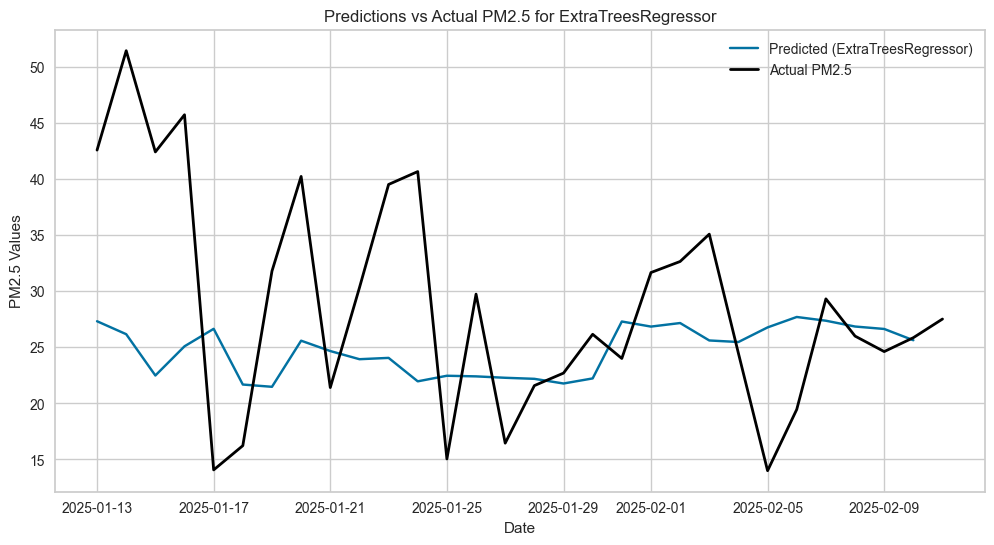

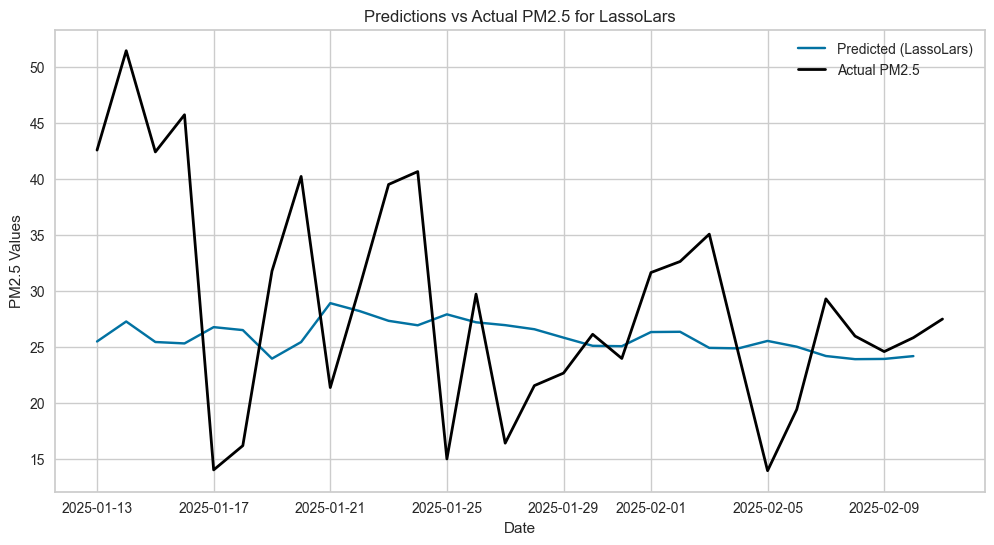

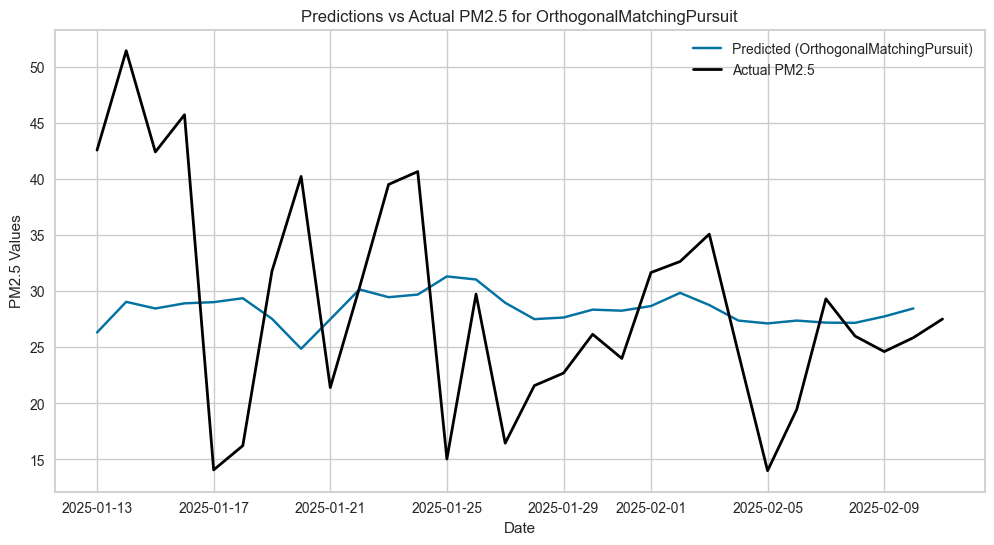

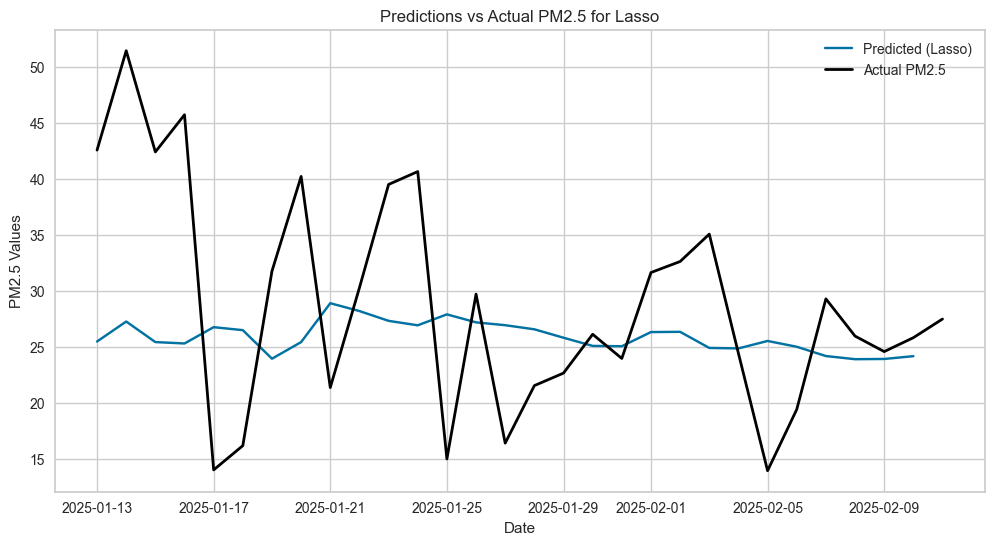

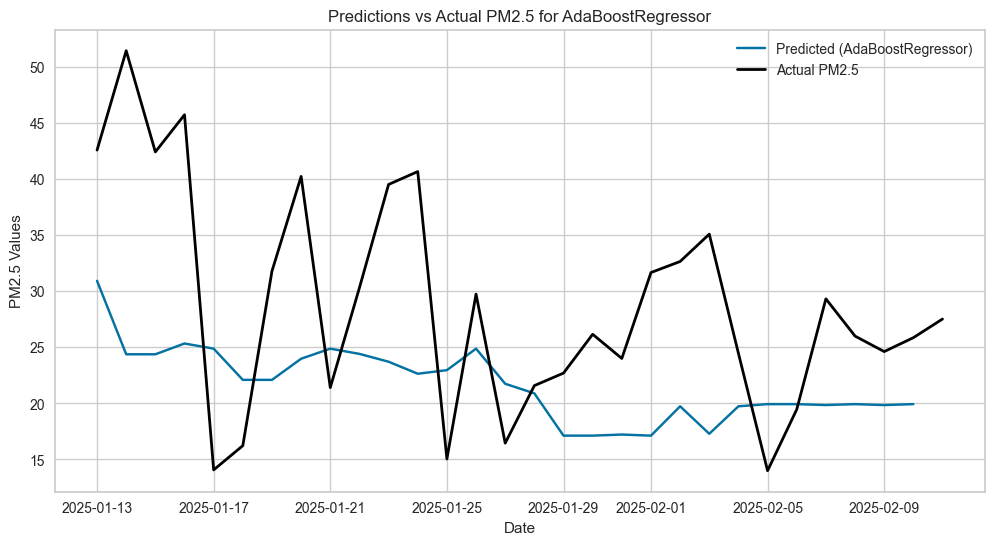

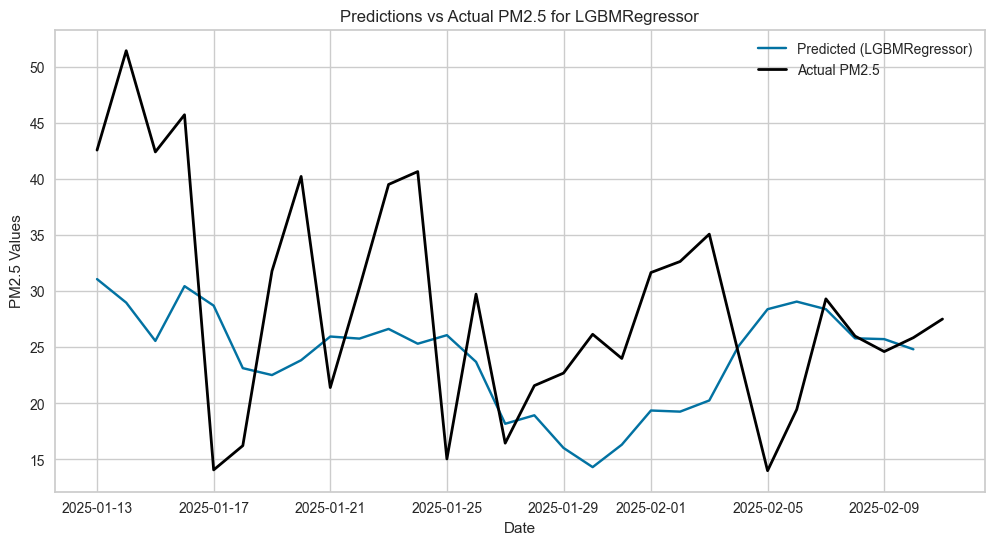

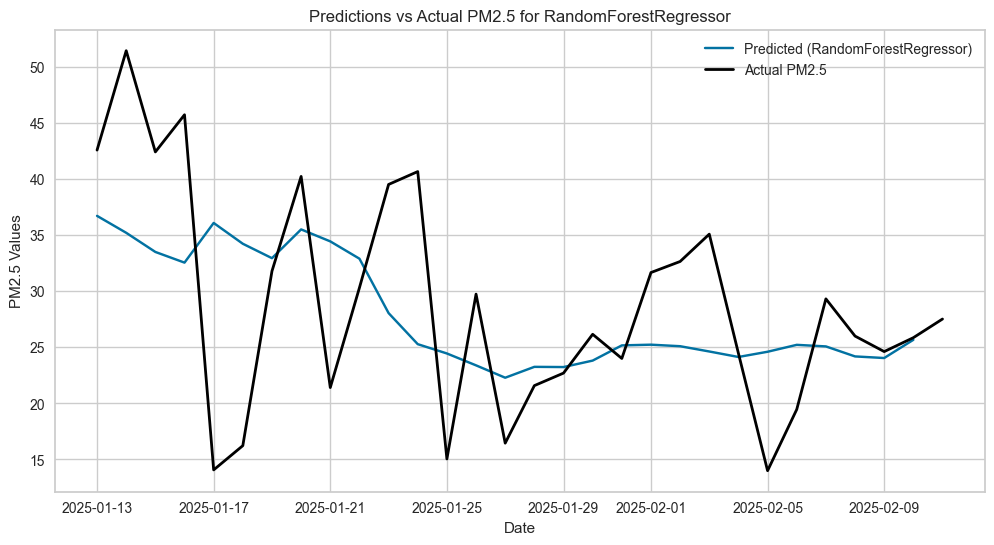

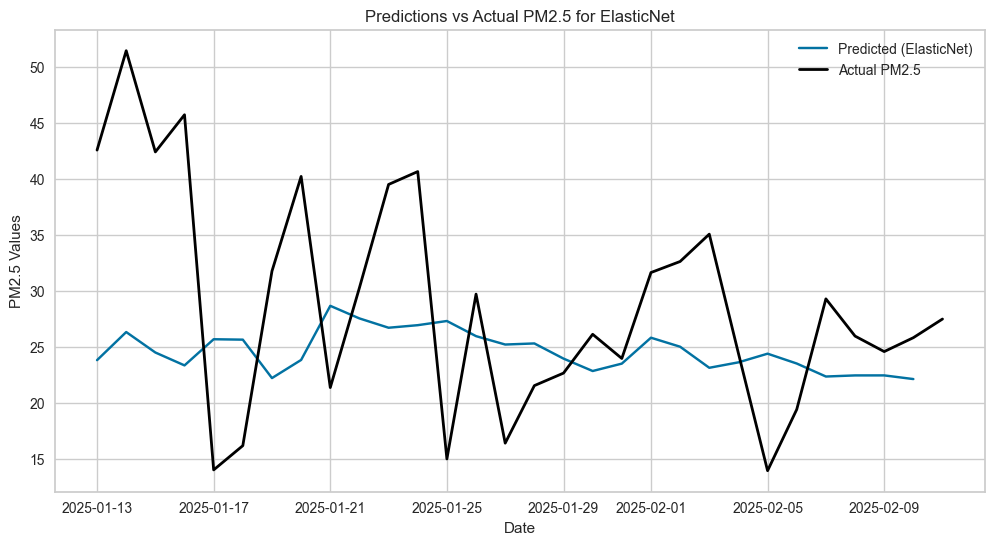

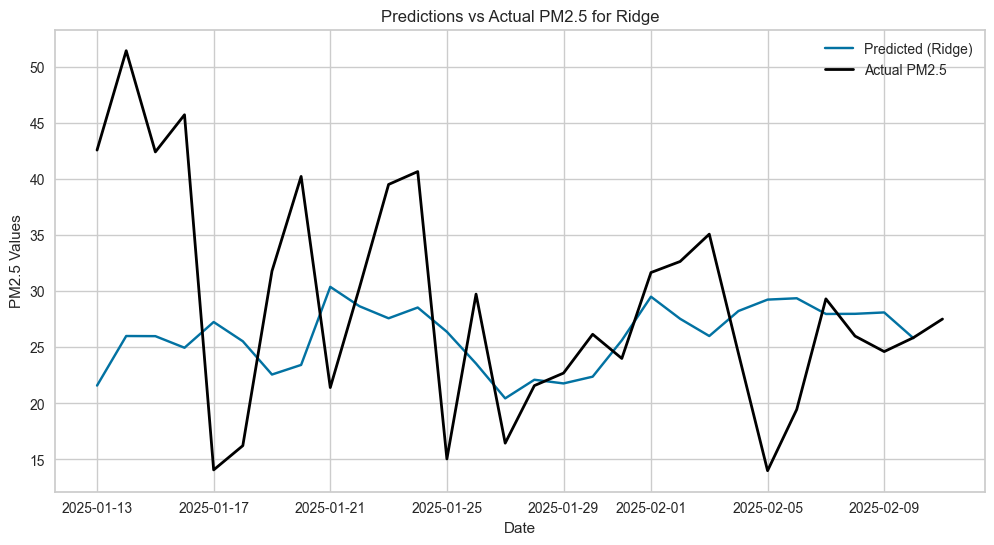

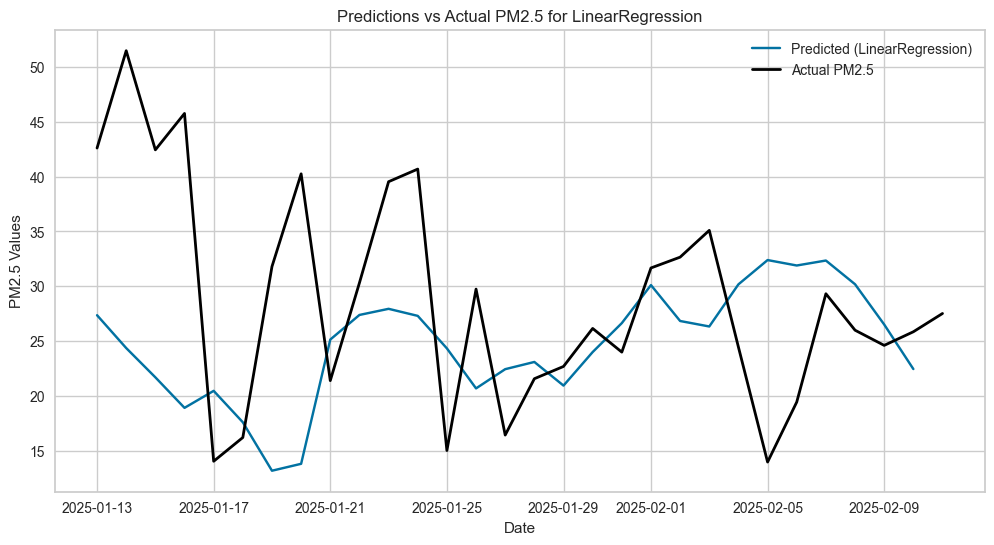

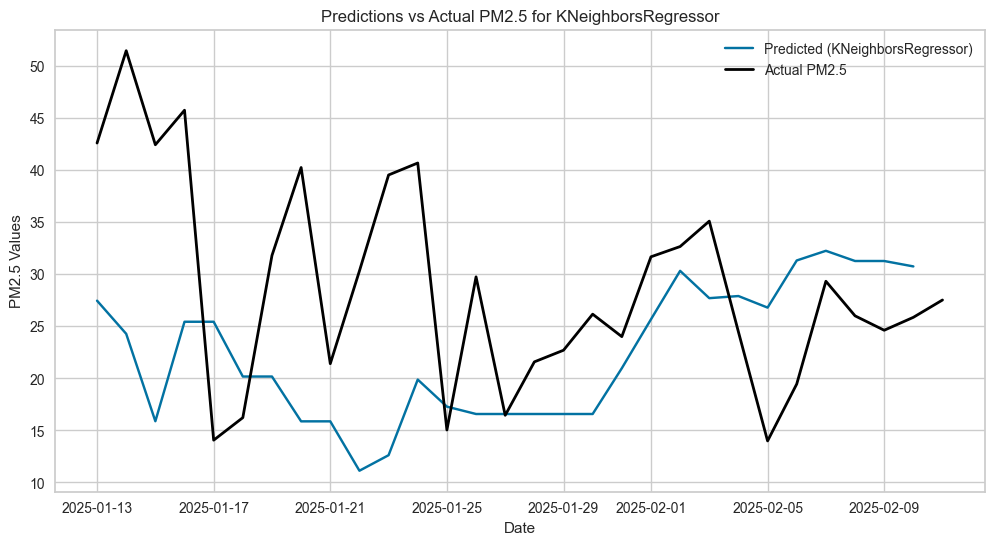

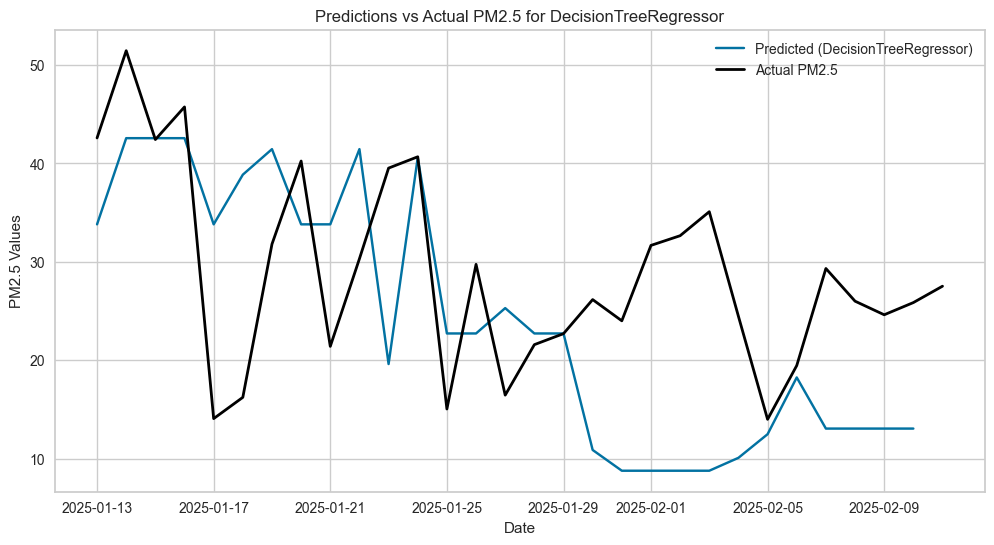

In [119]:
import pandas as pd
import matplotlib.pyplot as plt

# แปลง index เป็น datetime และลบเวลาออก
x = data_filtered.copy()
x.index = pd.to_datetime(x.index).normalize()

# เก็บผลลัพธ์ของแต่ละโมเดล
result_dict = {}

# รายชื่อโมเดลทั้งหมดจาก best_list
model_names = {model.__class__.__name__: model for model in best}

start_date = "2025-01-13"
end_date = "2025-02-11"

# วนลูปผ่านทุกโมเดล
for model_name, model in model_names.items():
    print(f"Processing model: {model_name}")

    data_compare = x.loc[:'2025-01-12'].copy()  # ใช้ copy() ป้องกัน Warning
    result = pd.DataFrame()

    for date in pd.date_range(start=start_date, end=end_date, freq="D"):
        # ลบเวลาออกจากวันที่
        date = pd.to_datetime(date).normalize()  # ลบเวลาออกจากตัวแปร date

        # ตรวจสอบว่าใน x มีข้อมูลในวันที่นี้หรือไม่
        if date not in x.index:
            print(f"⚠️ Warning: Date {date} not found in x index.")
            continue

        # ดึงข้อมูลของวันที่ต้องการ
        test_1 = x.loc[[date]].copy()

        # ใส่เข้าไป
        data_compare = pd.concat([data_compare, test_1], axis=0)

        for i in range(2,rolling_size+1):
            test_1[f'pm_2_5_rolling_{i}'] = data_compare['pm_2_5'].rolling(window=i).mean().shift(1)

        # เพิ่ม lag feature
        for i in range(1, lag_size + 1):
            test_1[f'pm_2_5_lag_{i}'] = data_compare['pm_2_5'].shift(i).iloc[-1]

        # ลบค่า NaN ที่เกิดจากการ shift
        test_1 = test_1.dropna()

        # ทำนายค่า
        predict_test_1 = exp1.predict_model(model, data=test_1)

        # อัปเดต data_compare
        predict_test_1.index = [date]  # กำหนด index เป็นวันที่พยากรณ์
        data_compare.loc[date, 'pm_2_5'] = predict_test_1['prediction_label'].values[0]

        # บันทึกผลลัพธ์
        result = pd.concat([result, predict_test_1], axis=0)

    # บันทึกผลลัพธ์ของโมเดลนี้ลง dict
    result_dict[model_name] = result

# --------------------------------------------
# พล็อตกราฟเปรียบเทียบทุกโมเดล
# --------------------------------------------
real_data = x.loc[start_date:end_date]

# วนลูปพล็อตกราฟทีละโมเดล
for model_name, result in result_dict.items():
    plt.figure(figsize=(12, 6))
    
    result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['pm_2_5']], axis=1)
    result_plot.columns = ['Predictions', 'Actual PM2.5']

    plt.plot(result_plot.index, result_plot['Predictions'], label=f"Predicted ({model_name})")
    plt.plot(real_data.index, real_data['pm_2_5'], label="Actual PM2.5", color="black", linewidth=2)
    
    # ตั้งค่ากราฟ
    plt.title(f'Predictions vs Actual PM2.5 for {model_name}')
    plt.xlabel('Date')
    plt.ylabel('PM2.5 Values')
    plt.legend()

    # แสดงกราฟ
    plt.show()

In [120]:
# --------------------------------------------
# คำนวณและแสดงผล Regression Metrics (หลังจากพล็อตกราฟ)
# --------------------------------------------
for model_name, result in result_dict.items():
    y_true = x.loc[start_date:end_date, 'pm_2_5']  # ค่าจริง
    y_pred = result['prediction_label'].shift(-1)  # ค่าพยากรณ์

    # ลบ NaN ที่เกิดจากการ shift
    valid_idx = y_pred.dropna().index
    y_true = y_true.loc[valid_idx]
    y_pred = y_pred.loc[valid_idx]

    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
    accuracy = 100 - mape  # เปลี่ยนเป็น Accuracy %

    # แสดงค่า Metrics ของโมเดลนี้
    print("\n📊 Model Performance Metrics:")
    print(f"Model: {model_name}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Accuracy: {accuracy:.2f}%")
    print("-" * 50)


📊 Model Performance Metrics:
Model: GradientBoostingRegressor
R² Score: -0.2141
Mean Absolute Error (MAE): 8.6944
Root Mean Squared Error (RMSE): 10.9998
Mean Absolute Percentage Error (MAPE): 38.88%
Accuracy: 61.12%
--------------------------------------------------

📊 Model Performance Metrics:
Model: BayesianRidge
R² Score: -0.1351
Mean Absolute Error (MAE): 8.5723
Root Mean Squared Error (RMSE): 10.6359
Mean Absolute Percentage Error (MAPE): 31.42%
Accuracy: 68.58%
--------------------------------------------------

📊 Model Performance Metrics:
Model: HuberRegressor
R² Score: -0.2296
Mean Absolute Error (MAE): 9.1535
Root Mean Squared Error (RMSE): 11.0697
Mean Absolute Percentage Error (MAPE): 32.90%
Accuracy: 67.10%
--------------------------------------------------

📊 Model Performance Metrics:
Model: ExtraTreesRegressor
R² Score: -0.1776
Mean Absolute Error (MAE): 8.4231
Root Mean Squared Error (RMSE): 10.8331
Mean Absolute Percentage Error (MAPE): 29.37%
Accuracy: 70.63%
----